In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import pandas as pd
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
# use the code below to make sure plot is shown in Notebook
%matplotlib inline 

In [30]:
os.getcwd()

'C:\\Users\\reddy\\Desktop\\DataSets\\McKinsey'

In [31]:
def read_data(filename):
    data = pd.read_table(filename, delimiter=',')
    data['DateTimeTransformed'] = pd.to_datetime(data.DateTime, format="%Y-%m-%d %H:%M:%S")
    data = data.sort_values(by='DateTimeTransformed')
    
    return data

def add_features(data):
    data['DayofWeek'] = data.DateTimeTransformed.dt.weekday
    data['Month'] = (pd.DatetimeIndex(data.DateTimeTransformed).strftime('%m')).astype(int)
    data['Week'] = (np.floor((data.DateTimeTransformed.dt.day)/7)).astype(int)
    data['TimeofDay'] = data.DateTimeTransformed.dt.hour
      
    return data

def create_features(data, i):
    enc = OneHotEncoder(n_values=[5, 7, 12, 24])
    j_data = data[data.Junction==i]
    ret = np.array(j_data[['Week', 'DayofWeek', 'Month', 'TimeofDay']])
    enc_array = enc.fit_transform(ret)
    
    return enc_array, enc
    

def new_figure():
    
    fig, ax = plt.subplots(figsize=(30, 10))
    return fig, ax


def plot_data(data, index=None):
    
    fig, ax = new_figure()
    indices = range(1, 5)

    if index is not None:
        indices = [index]

    for i in indices:
        junction_data = data[data.Junction == i]
        junction_data.plot(x='DateTimeTransformed', y='Vehicles',
                           ax=ax, label='Junction %d'%i)

def get_linear_trend(model, X, y):

    y_trend = np.dot(X, model.coef_) + model.intercept_
    y_rem = y/y_trend      #multiplicative model
    return y_trend, y_rem
    
def plot_model(model, X, y):

    fig, ax = new_figure()
    y_trend, y_rem = get_linear_trend(model, X, y)

    ax.plot(X[:, 0], y_trend, label='trend')
    ax.plot(X[:, 0], y, alpha=0.5, color='blue', label='data')    
    ax.plot(X[:, 0], y_rem, alpha=0.5, color='green', label='data-rem')

    ax.legend()
    ax.grid(True)
     
def get_junction_data(data, i):

    j_data = data[data.Junction == i]
    y = np.array(j_data.Vehicles)
    X = np.arange(y.shape[0])
    X = X[:, np.newaxis]
    
    return X, y

def fit_model(train_data, test_data, i):
    X_train, y_train = get_junction_data(train_data, i)
    #fig, ax = new_figure()
    #ax.plot(X_train[:, 0], y_train, alpha = 0.5, color = "green")
    test_junction = test_data[test_data.Junction==i]
    
    model = LinearRegression()
    model.fit(X_train, y_train)    
    y_tr, y_rem = get_linear_trend(model, X_train, y_train)                     # linear trend
    #fig, ax = new_figure()
    #ax.plot(X_train[:, 0], y_train, alpha = 0.5, color = "green")
    #ax.plot(X_train[:, 0], y_tr, color = "black")
    #fig, ax = new_figure()
    #ax.plot(X_train[:, 0], y_rem, color = "orange")
    
    features, enc = create_features(train_data, i)                             #what features
    #regr = RandomForestRegressor()
    regr = SVR()
    #gsCV = GridSearchCV(regr, param_grid={'n_estimators':[20, 100, 250, 500]}, n_jobs = -1)
    gsCV = GridSearchCV(regr, param_grid={'C':[0.25, 0.5, 0.75, 10]}, n_jobs = -1)
    gsCV.fit(features, y_rem)
    print(gsCV.best_params_)
    
    len_train = len(X_train)
    len_predict = len(test_junction)
    X_test = np.arange(len_train, len_train+len_predict)
    X_test = X_test.reshape(-1, 1)
    Y_linear_predict = model.predict(X_test)
      
    test_enc = np.array(test_junction[['Week', 'DayofWeek', 'Month', 'TimeofDay']])
    features_test = enc.transform(test_enc)
    
    Y_seasonal_predict = gsCV.predict(features_test)
    
    Y_predict = Y_linear_predict*Y_seasonal_predict
    
    fig, ax = new_figure()
    ax.plot(X_train[:, 0], y_train, alpha = 0.5, color = "green")
    ax.plot(X_test[:, 0], Y_predict, alpha = 0.5, color = "blue")
    
    return Y_predict
    
    
    

{'C': 10}
{'C': 0.75}
{'C': 0.25}
{'C': 0.75}


,DateTime,Junction,ID,DateTimeTransformed,DayofWeek,Month,Week,TimeofDay,Vehicles
0,2017-07-01 00:00:00,1,20170701001,2017-07-01 00:00:00,5,7,0,0,63
2952,2017-07-01 00:00:00,2,20170701002,2017-07-01 00:00:00,5,7,0,0,19
8856,2017-07-01 00:00:00,4,20170701004,2017-07-01 00:00:00,5,7,0,0,6
5904,2017-07-01 00:00:00,3,20170701003,2017-07-01 00:00:00,5,7,0,0,14
8857,2017-07-01 01:00:00,4,20170701014,2017-07-01 01:00:00,5,7,0,1,6


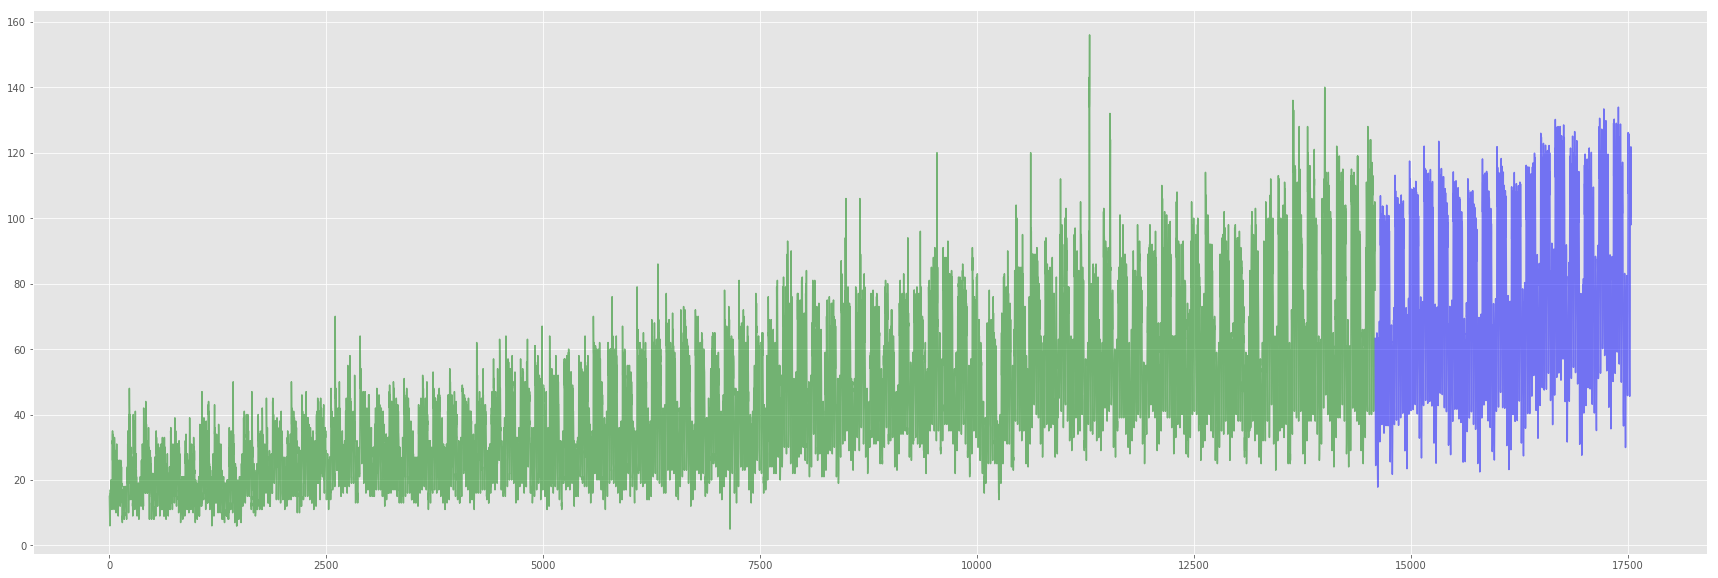

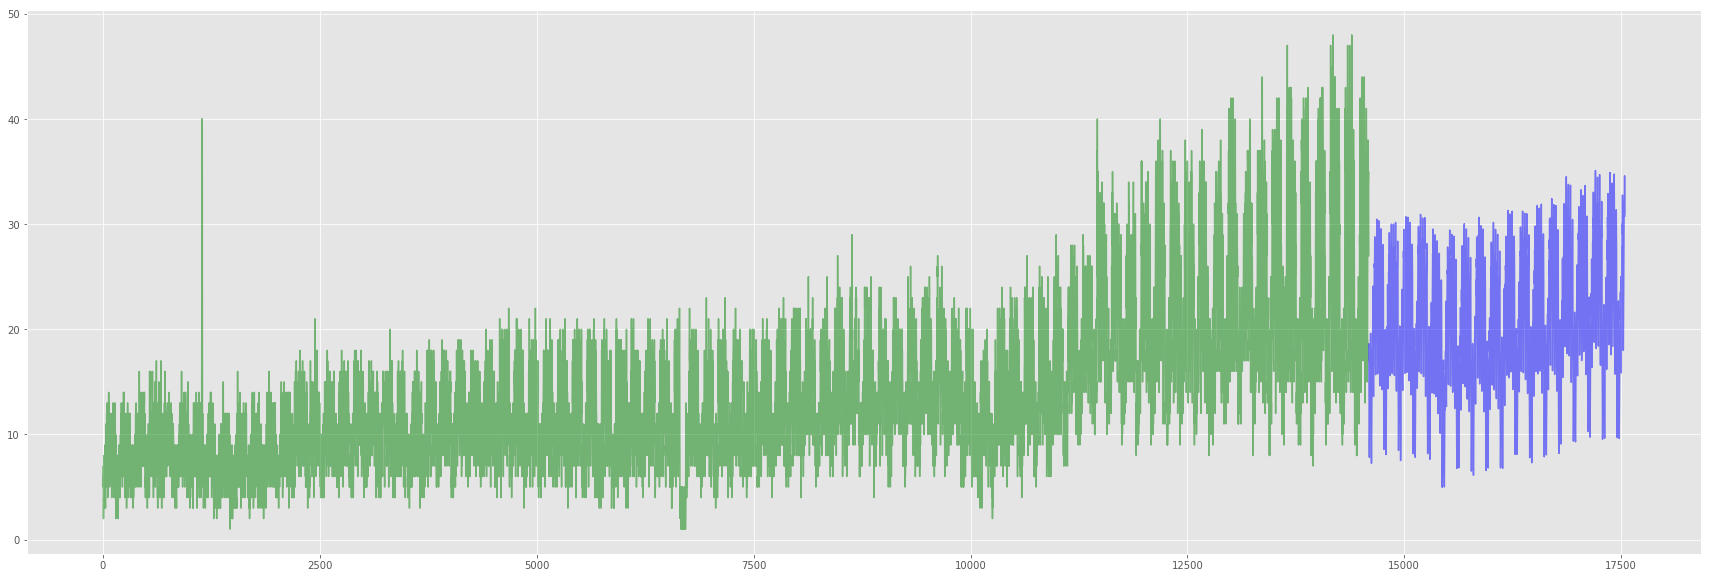

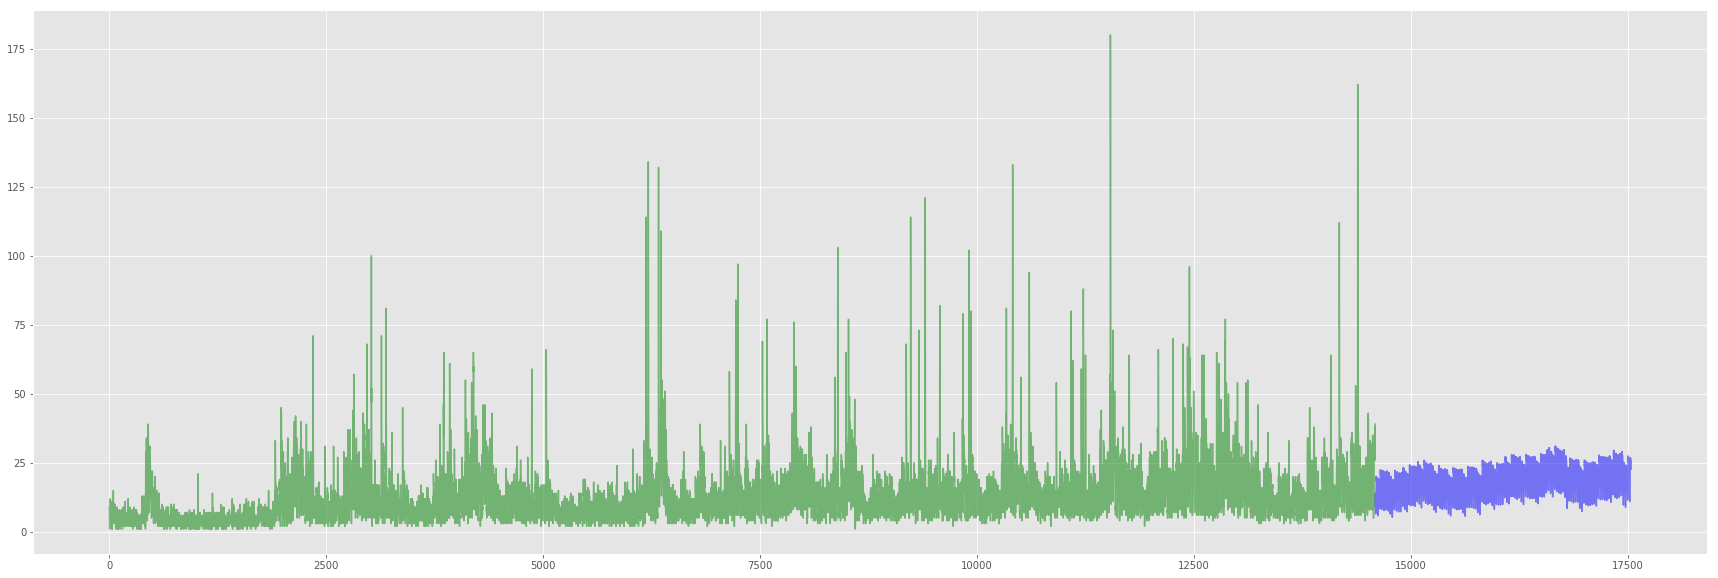

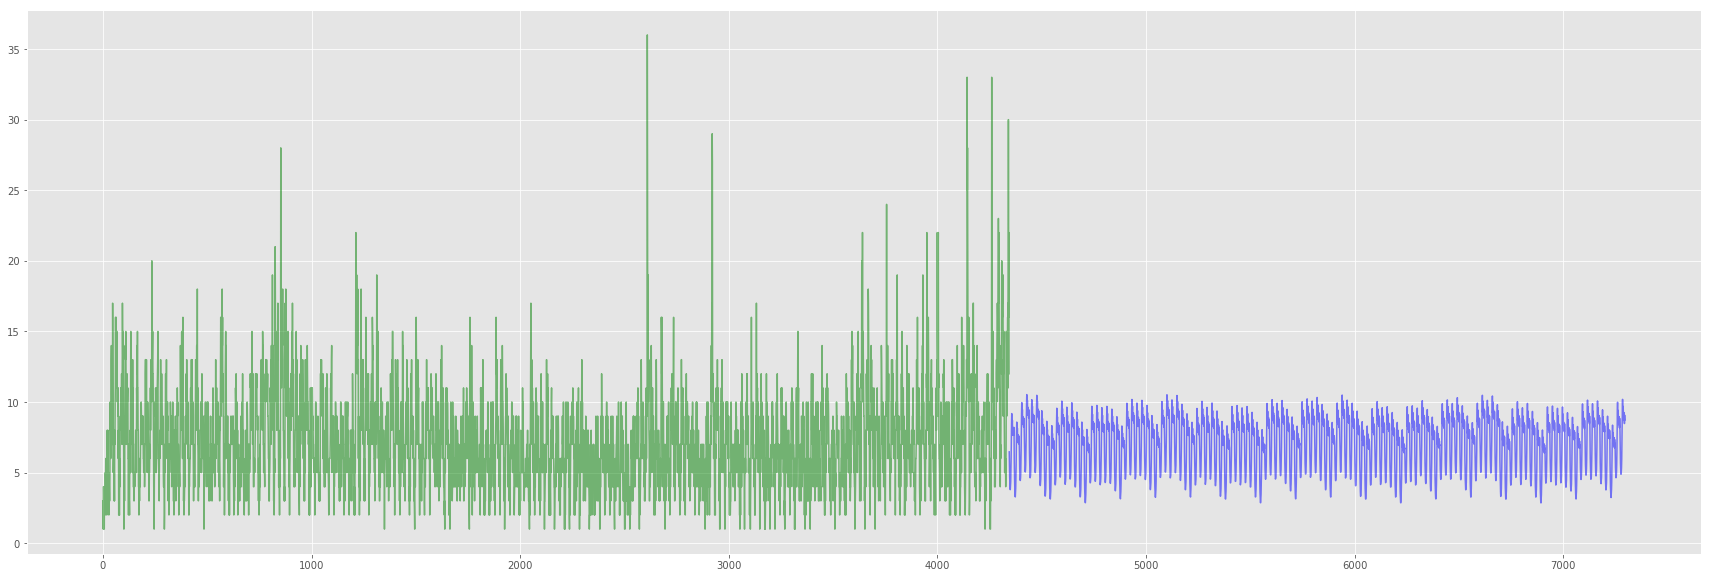

In [32]:
train = read_data('train.csv')
train = add_features(train)

test = read_data('test.csv')
test = add_features(test)
test['Vehicles'] = len(test) * [None]

for junction_id in range(1,5):
    vehicle_predict = fit_model(train, test, junction_id)
    test.loc[test.Junction==junction_id, 'Vehicles'] = (np.round(vehicle_predict,0)).astype(int)
                                                      
test.head()


In [33]:
(test[['Vehicles', 'ID']]).to_csv("Submission2.csv", index = False)